# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import Imputer, StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [5]:
azdias.AGER_TYP.value_counts()
azdias.FINANZ_ANLEGER.value_counts()

5    234508
1    210812
2    161286
4    143597
3    141018
Name: FINANZ_ANLEGER, dtype: int64

In [6]:
customers.info()
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [7]:
feat_info.info()
feat_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
..                    ...               ...          ...                ...
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
60            KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61            KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62            KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63            KBA05_ANTG4     microcell_rr3      ordinal               [-1]
64           KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]
65              KBA05_GBZ     microcell_rr3      ordinal             [-1,0]
66               BALLRAUM          postcode      ordinal               [-1]
67               EWDICHTE          postcode      ordinal               [-1]
68             INNENSTADT          postcode      ordinal               [-1]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal             [-1,0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal             [-1,0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info.set_index('attribute', inplace=True)

for column in azdias.columns:
    print(column)
    print(feat_info.loc[column].missing_or_unknown)
    if 'X' in feat_info.loc[column].missing_or_unknown:
        azdias[column] = azdias[column].map(lambda x: np.nan if str(x) in feat_info.loc[column].missing_or_unknown else x)
    elif feat_info.loc[column].missing_or_unknown != '[]':
        azdias[column].replace(eval(feat_info.loc[column].missing_or_unknown), np.nan, inplace=True)
    print (azdias[column].describe())

AGER_TYP
[-1,0]
count    205378.000000
mean          1.743410
std           0.674312
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: AGER_TYP, dtype: float64
ALTERSKATEGORIE_GROB
[-1,0,9]
count    888340.000000
mean          2.757217
std           1.009951
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64
ANREDE_KZ
[-1,0]
count    891221.000000
mean          1.522098
std           0.499512
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: ANREDE_KZ, dtype: float64
CJT_GESAMTTYP
[0]
count    886367.000000
mean          3.632838
std           1.595021
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: CJT_GESAMTTYP, dtype: float64
FINANZ_MINIMALIST
[-1]
count    891221.00

In [9]:
azdias.AGER_TYP.value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [10]:
azdias.to_csv('azdias_with_nan.csv', sep=';', index=False)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [4]:
azdias = pd.read_csv('azdias_with_nan.csv', sep=';')
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing = azdias.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)

missing.describe()

count        61.000000
mean     137871.163934
std      157022.195928
min        2881.000000
25%       93148.000000
50%       99352.000000
75%      133324.000000
max      889061.000000
dtype: float64

Text(0,0.5,'Count of columns with this number of missing records')

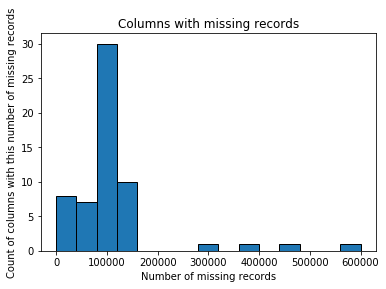

In [6]:
plt.hist(missing, range=(0, 600000), bins=15, edgecolor='k')
plt.title('Columns with missing records')
plt.xlabel('Number of missing records')
plt.ylabel('Count of columns with this number of missing records')

Text(0,0.5,'Number of missing records')

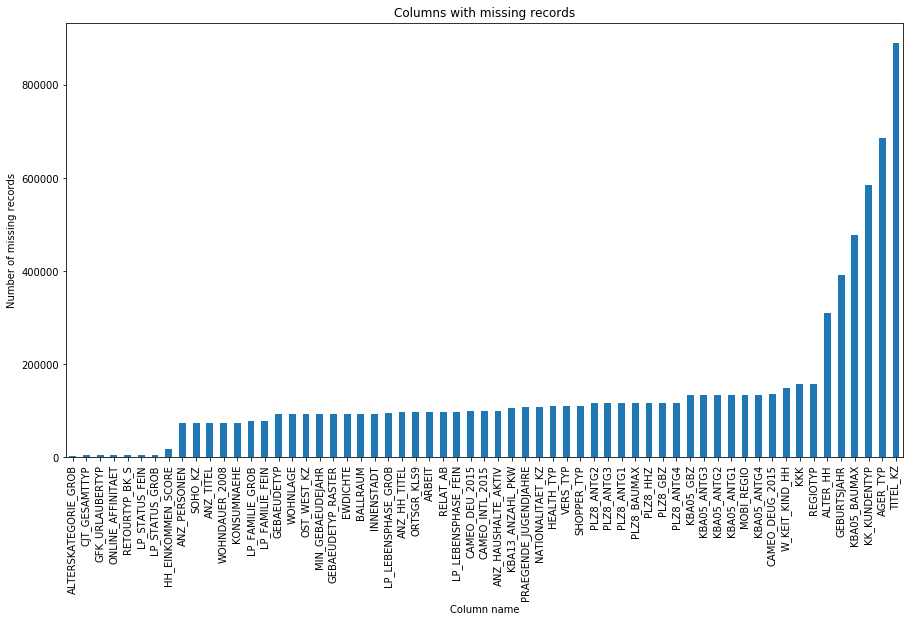

In [7]:
missing.plot.bar(figsize=(15, 8))
plt.title('Columns with missing records')
plt.xlabel('Column name')
plt.ylabel('Number of missing records')

#### Investigate patterns in the amount of missing data in each column.

There are 61 columns with missing recrods. The columns with more than 250000 missing records can be considered as outliers. The same categorical columns have similar amount of missing data. 

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_outliers = missing[missing>200000]
print(missing_outliers.index)
azdias.drop(list(missing_outliers.index), axis=1, inplace=True)

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')


In [9]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)


61 columns of the azdias dataset have missing data, with 8 columns of almost complete records, 6 columns lacking more than 250000 records, and most columns having less than 150000 missing records.

The 6 columns that lacking more than 250000 records are 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'. Probably people don't feel like answering the private questions about their birthday, house size, constomer behaviour, academic title.

Most columns have simliar number of missing records. Some columns of the same category even have the exact same number of missing records, like (KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4) and (PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ). Probably it's because the same person doesn't answer questions of a certain category. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?

missing_col = azdias.isnull().sum(axis=1)
missing_col.sort_values(inplace=True)
missing_col.describe()

count    891221.000000
mean          5.690526
std          13.222070
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

Text(0,0.5,'Number of rows')

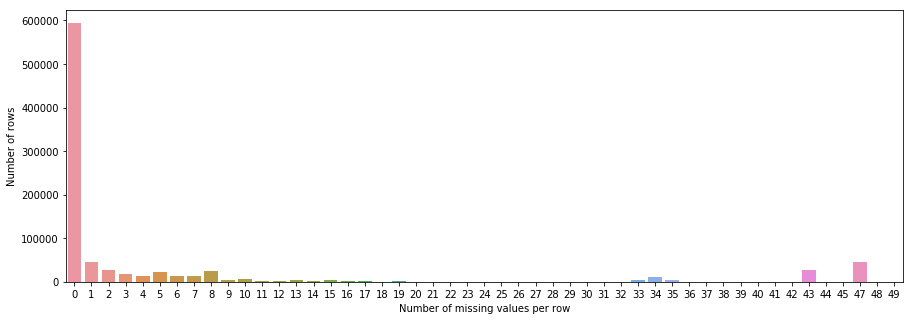

In [12]:
plt.figure(figsize=(15,5))
ax = sns.countplot(missing_col)
ax.set_xlabel('Number of missing values per row')
ax.set_ylabel('Number of rows')

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_low_rows = azdias.iloc[list(missing_col <20)]
azdias_high_rows = azdias.iloc[list(missing_col >=20)]

In [14]:
azdias_low_rows.shape

(797073, 79)

In [15]:
azdias_high_rows.shape

(94148, 79)

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#pick 5 columns with the no missing values
missing = azdias.isnull().sum()
no_missing = missing[missing==0]
no_missing.sort_values(inplace=True)
print(no_missing)
col_chosen = ['ANREDE_KZ', 'SEMIO_KRIT', 'GREEN_AVANTGARDE', 'FINANZTYP', 'ZABEOTYP']

ANREDE_KZ                0
SEMIO_PFLICHT            0
SEMIO_KAEM               0
SEMIO_DOM                0
SEMIO_KRIT               0
SEMIO_RAT                0
SEMIO_KULT               0
SEMIO_ERL                0
SEMIO_LUST               0
SEMIO_VERT               0
SEMIO_MAT                0
SEMIO_REL                0
SEMIO_FAM                0
SEMIO_SOZ                0
GREEN_AVANTGARDE         0
FINANZTYP                0
FINANZ_HAUSBAUER         0
FINANZ_UNAUFFAELLIGER    0
FINANZ_ANLEGER           0
FINANZ_VORSORGER         0
FINANZ_SPARER            0
FINANZ_MINIMALIST        0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64


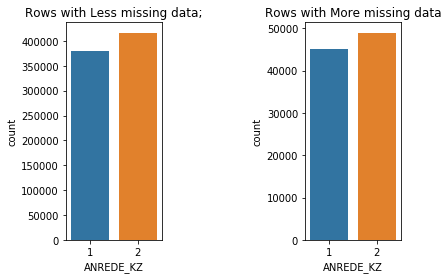

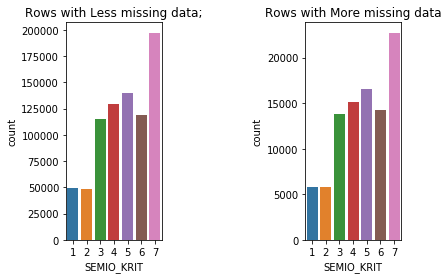

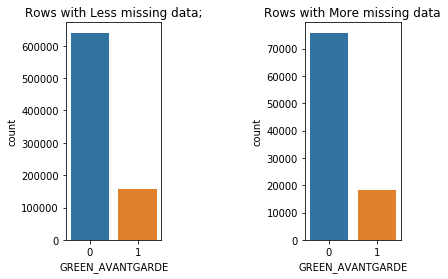

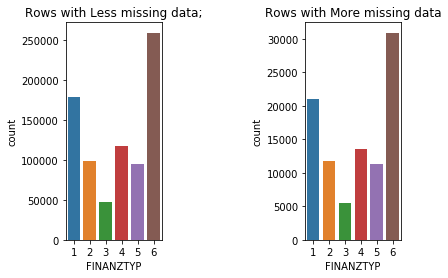

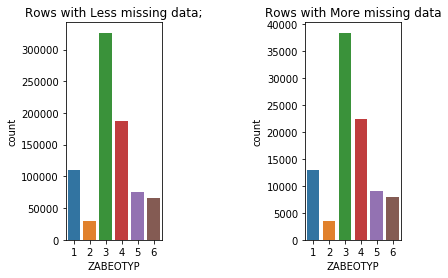

In [17]:
for i, col in enumerate(col_chosen):
    fig, (ax_low, ax_high) = plt.subplots(1, 2)
    sns.countplot(azdias_low_rows[col], ax=ax_low)
    sns.countplot(azdias_high_rows[col], ax=ax_high)
    ax_low.set_title('Rows with Less missing data;')
    ax_high.set_title('Rows with More missing data')
    fig.subplots_adjust(wspace=1.5)

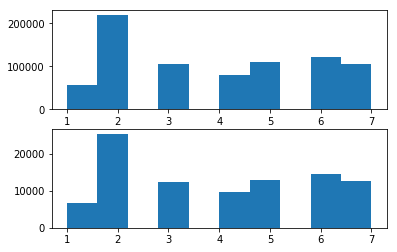

In [18]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.hist(azdias_low_rows['SEMIO_SOZ'])
ax2 = fig1.add_subplot(212)
ax2.hist(azdias_high_rows['SEMIO_SOZ'])

plt.show()

In [18]:
azdias_low_rows.to_csv('azdias_low_rows.csv', sep=';', index=False)

In [19]:
from scipy.stats import ks_2samp

comp_df = pd.DataFrame(azdias.columns, columns=['col'])
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(azdias_low_rows, azdias_high_rows, azdias_low_rows.columns.values)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df.head()

col  stats   pvalues
0  ALTERSKATEGORIE_GROB    1.0  0.011066
1             ANREDE_KZ    1.0  0.097027
2         CJT_GESAMTTYP    1.0  0.001300
3     FINANZ_MINIMALIST    1.0  0.003781
4         FINANZ_SPARER    1.0  0.003781

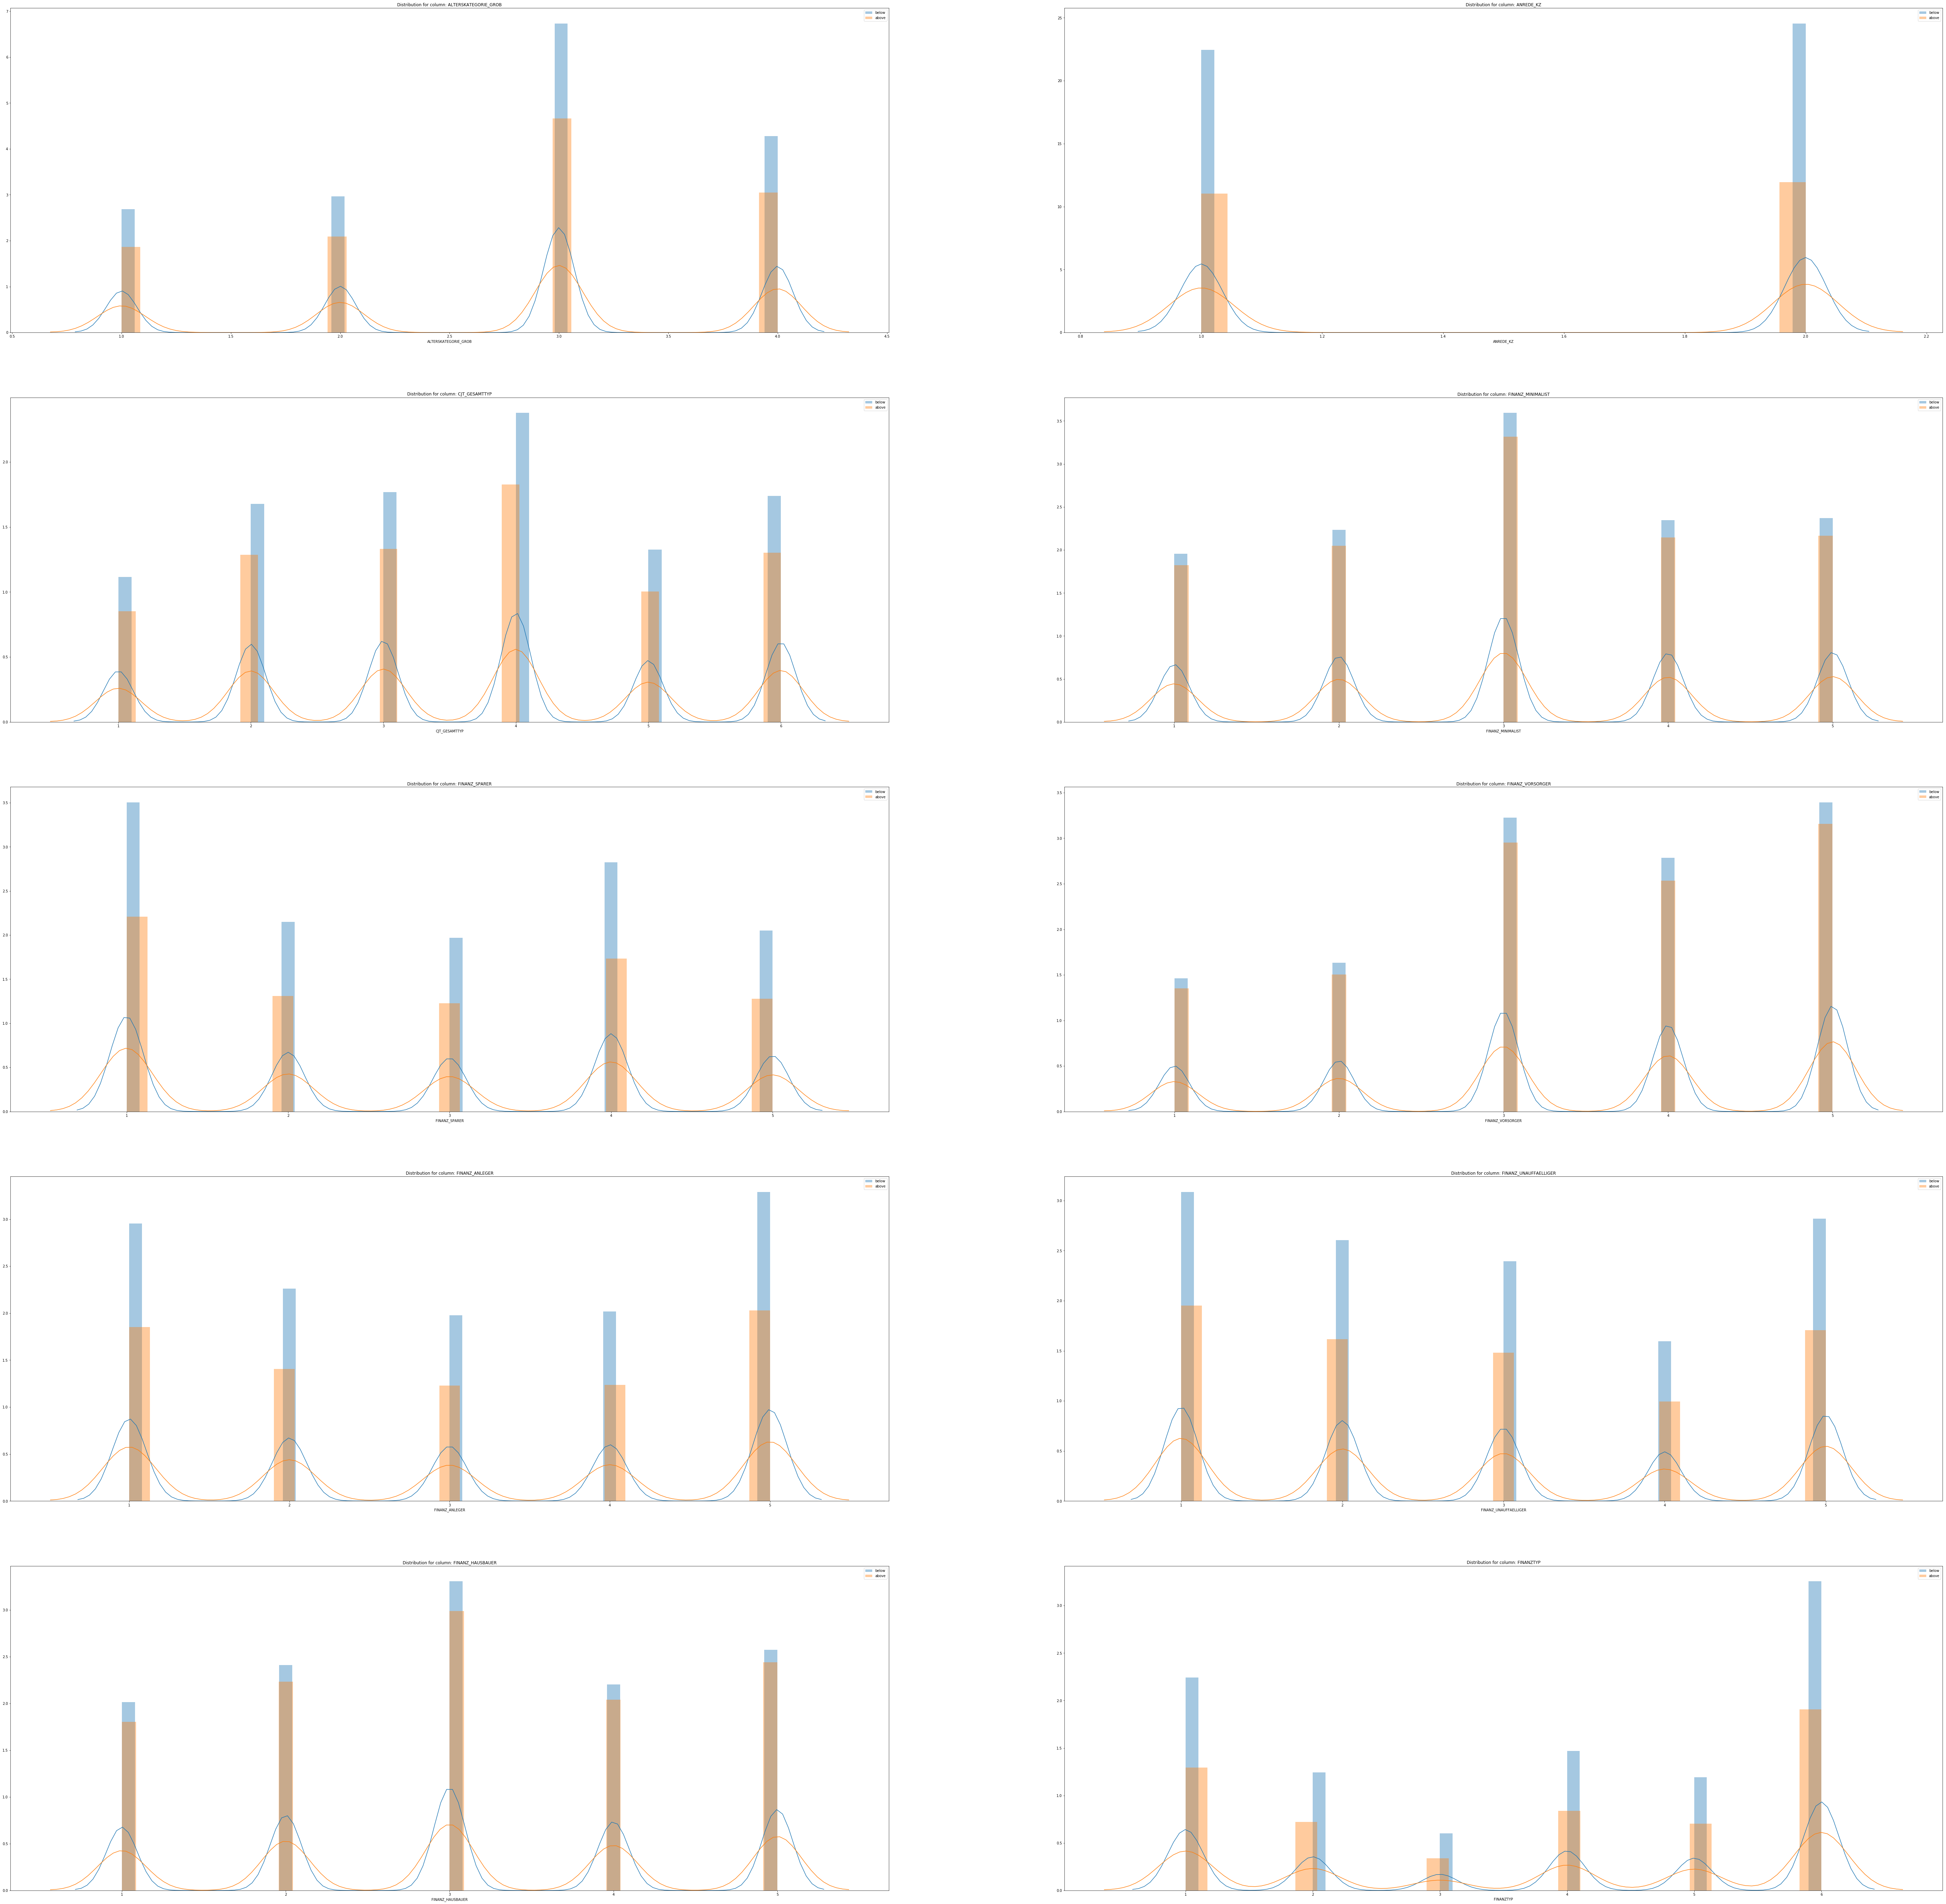

In [20]:
plt.figure(figsize=(100,100))
for i, col in enumerate(azdias.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_low_rows[col][azdias_low_rows[col].notnull()], label='below')
    sns.distplot(azdias_high_rows[col][azdias_high_rows[col].notnull()], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Based on the countplot, I divided the data into two subsets, one with <20 missing values per row, the other with >=20 missing values per row. 
By selecting 5 columns of no missing data, I'm a bit surprised to see that the distributions of these 5 non-missing features look similar between these two subsets. So I can say that dropping the second subset with >=20 missing values per row from the azdias data is no problem.

So for the later data processing, I will only use the first subset with <20 missing values per row.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [2]:
# How many features are there of each data type?
azdias = pd.read_csv('azdias_low_rows.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
azdias.NATIONALITAET_KZ.value_counts()

1.0    611578
2.0     58444
3.0     29883
Name: NATIONALITAET_KZ, dtype: int64

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info_categorical = feat_info[feat_info.type=='categorical']

for col in feat_info_categorical.attribute:
    print(col)
    if col in azdias.columns: 
        print (col, azdias[col].nunique(), azdias[col].dtype)

AGER_TYP
ANREDE_KZ
ANREDE_KZ 2 int64
CJT_GESAMTTYP
CJT_GESAMTTYP 6 float64
FINANZTYP
FINANZTYP 6 int64
GFK_URLAUBERTYP
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ
NATIONALITAET_KZ 3 float64
SHOPPER_TYP
SHOPPER_TYP 4 float64
SOHO_KZ
SOHO_KZ 2 float64
TITEL_KZ
VERS_TYP
VERS_TYP 2 float64
ZABEOTYP
ZABEOTYP 6 int64
KK_KUNDENTYP
GEBAEUDETYP
GEBAEUDETYP 6 float64
OST_WEST_KZ
OST_WEST_KZ 2 object
CAMEO_DEUG_2015
CAMEO_DEUG_2015 8 float64
CAMEO_DEU_2015
CAMEO_DEU_2015 44 object


In [23]:
for col in feat_info_categorical.attribute:
    if col in azdias.columns: 
        if azdias[col].nunique() >2: #drop the multi-level
            print("dropping ", col)
            azdias.drop(col, axis=1, inplace=True)

dropping  CJT_GESAMTTYP
dropping  FINANZTYP
dropping  GFK_URLAUBERTYP
dropping  LP_FAMILIE_FEIN
dropping  LP_FAMILIE_GROB
dropping  LP_STATUS_FEIN
dropping  LP_STATUS_GROB
dropping  NATIONALITAET_KZ
dropping  SHOPPER_TYP
dropping  ZABEOTYP
dropping  GEBAEUDETYP
dropping  CAMEO_DEUG_2015
dropping  CAMEO_DEU_2015


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias['OST_KZ'] = azdias.OST_WEST_KZ.replace({'O':1, 'W':0})
azdias['OST_KZ'].value_counts()
azdias.drop('OST_WEST_KZ', axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I dropped the multi-level categorical features from azdias, and re-encoded the values of the binary categorical feature "OST_WEST_KZ" as numbers. While the other binary categorical features remain the same.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_map = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
movement_map = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias.PRAEGENDE_JUGENDJAHRE.map(decade_map)
print(azdias.PRAEGENDE_JUGENDJAHRE_DECADE.value_counts())
azdias['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = azdias.PRAEGENDE_JUGENDJAHRE.map(movement_map)
print(azdias.PRAEGENDE_JUGENDJAHRE_MAINSTREAM.value_counts())
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

90.0    206721
70.0    160643
80.0    135745
60.0    103860
50.0     67408
40.0     25635
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
1.0    543105
0.0    156907
Name: PRAEGENDE_JUGENDJAHRE_MAINSTREAM, dtype: int64


In [26]:
def get_wealth(number):
    tens = int(str(number)[0])
    return tens

def get_life_stage(number):
    ones = int(str(number)[1])
    return ones

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015_WEALTH'] = azdias.CAMEO_INTL_2015.map(get_wealth, na_action='ignore') 
print(azdias.CAMEO_INTL_2015_WEALTH.value_counts())
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias.CAMEO_INTL_2015.map(get_life_stage, na_action='ignore') 
print(azdias.CAMEO_INTL_2015_LIFESTAGE.value_counts())
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

5.0    199689
2.0    170550
4.0    169663
1.0    107000
3.0     61089
Name: CAMEO_INTL_2015_WEALTH, dtype: int64
1.0    218871
4.0    208174
3.0    107261
5.0    104567
2.0     69118
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: int64


In [28]:
azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)

In [29]:
azdias.to_csv('azdias_with_reencoded_features.csv', sep=';', index=False)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I re-encoded the PRAEGENDE_JUGENDJAHRE into PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MAINSTREAM, also re-encoded the CAMEO_INTL_2015 into CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE. 

For the rest mixed features, I dropped them all:
1. LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, because they provide the duplicate information about people's wealth and life stage. 
2. WOHNLAGE, because it provides duplicate information as REGIOTYP. 
3. PLZ8_BAUMAX, because it provides duplicate information as other PLZ8 features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [2]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias = pd.read_csv('azdias_with_reencoded_features.csv', sep=';')
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info_categorical = feat_info[feat_info.type=='categorical']
feat_info.set_index('attribute', inplace=True)

In [4]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    for column in df.columns:
        if 'X' in feat_info.loc[column].missing_or_unknown:
            df[column] = df[column].map(lambda x: np.nan if str(x) in feat_info.loc[column].missing_or_unknown else x)
        elif feat_info.loc[column].missing_or_unknown != '[]':
            df[column].replace(eval(feat_info.loc[column].missing_or_unknown), np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    col_to_drop = ['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 
       'TITEL_KZ']
    df.drop(col_to_drop, axis=1, inplace=True)
    
    missing_col = df.isnull().sum(axis=1)
    df = df.iloc[list(missing_col <20)]
    
    # select, re-encode, and engineer column values.
    for col in feat_info_categorical.attribute:
        if col in df.columns: 
            if df[col].nunique() >2: 
                df.drop(col, axis=1, inplace=True)
    
    df['OST_KZ'] = df.OST_WEST_KZ.replace({'O':1, 'W':0})
    df.drop('OST_WEST_KZ', axis=1, inplace=True)
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df.PRAEGENDE_JUGENDJAHRE.map(decade_map)
    df['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = df.PRAEGENDE_JUGENDJAHRE.map(movement_map)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df['CAMEO_INTL_2015_WEALTH'] = df.CAMEO_INTL_2015.map(get_wealth, na_action='ignore') 
    df['CAMEO_INTL_2015_LIFESTAGE'] = df.CAMEO_INTL_2015.map(get_life_stage, na_action='ignore') 
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    col_to_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    df.drop(col_to_drop, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

missing_records = azdias.isnull().sum(axis=0)
print(missing_records[missing_records>0])

ALTERSKATEGORIE_GROB                  2598
HEALTH_TYP                           99766
RETOURTYP_BK_S                        4357
SOHO_KZ                              66029
VERS_TYP                             99766
ANZ_PERSONEN                         66029
ANZ_TITEL                            66029
HH_EINKOMMEN_SCORE                   16461
W_KEIT_KIND_HH                      132584
WOHNDAUER_2008                       66029
ANZ_HAUSHALTE_AKTIV                  89418
ANZ_HH_TITEL                         87080
KONSUMNAEHE                          66465
MIN_GEBAEUDEJAHR                     83639
KBA05_ANTG1                         119643
KBA05_ANTG2                         119643
KBA05_ANTG3                         119643
KBA05_ANTG4                         119643
KBA05_GBZ                           119643
BALLRAUM                             84130
EWDICHTE                             84130
INNENSTADT                           84130
GEBAEUDETYP_RASTER                   83646
KKK        

In [6]:
imp = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)
azdias_imputed = pd.DataFrame(imp.fit_transform(azdias), columns=azdias.columns)

In [7]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)
azdias_scaled.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -0.751163  -1.045795          -0.056977       0.804580   
1             -1.742986   0.956210          -1.571062       1.487485   
2              0.240660   0.956210          -1.571062       0.804580   
3              1.232483   0.956210           0.700065      -0.561229   
4              0.240660  -1.045795           0.700065       0.121675   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -0.303281        1.285112               1.428149         -0.053854   
1         -1.059871        1.285112               0.755654          1.424395   
2         -1.816462       -0.676323               0.083158          1.424395   
3          1.209899       -0.676323              -1.261832         -0.792978   
4          0.453309       -1.330134               0.083158         -0.792978   

   GREEN_AVANTGARDE  HEALTH_TYP            ...              PLZ8_HHZ  \
0         -0.495079    0.937673            ...             -0.571769   
1         -0.495079    0.937673            ...              1.575956   
2          2.019878    0.937673            ...              0.502093   
3         -0.495079   -0.386137            ...             -0.571769   
4         -0.495079    0.937673            ...             -0.571769   

   PLZ8_GBZ    ARBEIT  ORTSGR_KLS9  RELAT_AB    OST_KZ  \
0 -0.318046  0.759035    -0.119796 -0.049353 -0.481575   
1  0.640302 -0.263065    -0.119796  0.729297 -0.481575   
2  0.640302 -0.263065    -0.119796 -0.828003 -0.481575   
3  0.640302 -1.285164    -1.039224 -0.049353 -0.481575   
4 -0.318046  0.759035     0.339918  1.507946 -0.481575   

   PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MAINSTREAM  \
0                      0.994583                          0.495079   
1                      0.994583                          0.495079   
2                      0.994583                         -2.019878   
3                     -0.364716                          0.495079   
4                     -0.364716                          0.495079   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFESTAGE  
0                1.040247                  -1.096042  
1                1.040247                  -1.096042  
2               -0.979628                   0.879845  
3               -1.652920                  -0.437413  
4                0.366955                   0.221216  

[5 rows x 64 columns]

In [8]:
azdias_scaled.describe()

ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          7.970730e+05  7.970730e+05       7.970730e+05   7.970730e+05   
mean          -1.256574e-16  3.806449e-17       1.342954e-16  -7.965908e-17   
std            1.000001e+00  1.000001e+00       1.000001e+00   1.000001e+00   
min           -1.742986e+00 -1.045795e+00      -1.571062e+00  -1.244134e+00   
25%           -7.511629e-01 -1.045795e+00      -8.140198e-01  -1.244134e+00   
50%            2.406599e-01  9.562103e-01      -5.697720e-02   1.216753e-01   
75%            1.232483e+00  9.562103e-01       7.000654e-01   8.045799e-01   
max            1.232483e+00  9.562103e-01       1.457108e+00   1.487485e+00   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      7.970730e+05    7.970730e+05           7.970730e+05   
mean       1.419351e-16   -5.081208e-17           1.049760e-16   
std        1.000001e+00    1.000001e+00           1.000001e+00   
min       -1.816462e+00   -1.330134e+00          -1.261832e+00   
25%       -3.032813e-01   -6.763229e-01          -5.893371e-01   
50%       -3.032813e-01   -2.251137e-02           8.315820e-02   
75%        1.209899e+00    1.285112e+00           7.556535e-01   
max        1.209899e+00    1.285112e+00           1.428149e+00   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE    HEALTH_TYP  \
count      7.970730e+05      7.970730e+05  7.970730e+05   
mean       2.003957e-17     -3.203835e-17 -1.431385e-16   
std        1.000001e+00      1.000001e+00  1.000001e+00   
min       -1.532102e+00     -4.950794e-01 -1.709947e+00   
25%       -7.929780e-01     -4.950794e-01 -3.861368e-01   
50%       -5.385376e-02     -4.950794e-01 -3.861368e-01   
75%        6.852705e-01     -4.950794e-01  9.376733e-01   
max        1.424395e+00      2.019878e+00  9.376733e-01   

                 ...                  PLZ8_HHZ      PLZ8_GBZ        ARBEIT  \
count            ...              7.970730e+05  7.970730e+05  7.970730e+05   
mean             ...             -1.332703e-16  3.137869e-17  4.849433e-17   
std              ...              1.000001e+00  1.000001e+00  1.000001e+00   
min              ...             -2.719494e+00 -2.234741e+00 -2.307263e+00   
25%              ...             -5.717693e-01 -3.180461e-01 -2.630645e-01   
50%              ...             -5.717693e-01 -3.180461e-01 -2.630645e-01   
75%              ...              5.020932e-01  6.403015e-01  7.590348e-01   
max              ...              1.575956e+00  1.598649e+00  1.781134e+00   

        ORTSGR_KLS9      RELAT_AB        OST_KZ  PRAEGENDE_JUGENDJAHRE_DECADE  \
count  7.970730e+05  7.970730e+05  7.970730e+05                  7.970730e+05   
mean  -1.491290e-16 -7.332985e-17  7.245624e-17                 -4.873658e-16   
std    1.000001e+00  1.000001e+00  1.000001e+00                  1.000001e+00   
min   -1.958652e+00 -1.606653e+00 -4.815745e-01                 -2.403665e+00   
25%   -5.795102e-01 -8.280031e-01 -4.815745e-01                 -3.647159e-01   
50%   -1.197962e-01 -4.935328e-02 -4.815745e-01                  3.149338e-01   
75%    7.996319e-01  7.292965e-01 -4.815745e-01                  9.945835e-01   
max    1.719060e+00  1.507946e+00  2.076522e+00                  9.945835e-01   

       PRAEGENDE_JUGENDJAHRE_MAINSTREAM  CAMEO_INTL_2015_WEALTH  \
count                      7.970730e+05            7.970730e+05   
mean                       3.203835e-17           -2.906094e-18   
std                        1.000001e+00            1.000001e+00   
min                       -2.019878e+00           -1.652920e+00   
25%                        4.950794e-01           -9.796281e-01   
50%                        4.950794e-01            3.669551e-01   
75%                        4.950794e-01            1.040247e+00   
max                        4.950794e-01            1.040247e+00   

       CAMEO_INTL_2015_LIFESTAGE  
count               7.970730e+05  
mean               -7.631618e-17  
std                 1.0000

In [9]:
azdias_scaled.to_csv('azdias_scaled.csv', sep=';', index=False)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I replaced all the Nan values in the first subset of azdias (<20 missing values per row) by the most frequent values in each column. Then each feature in this subset was scaled to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [10]:
# Apply PCA to the data.

azdias = pd.read_csv('azdias_scaled.csv', sep=';')
pca = PCA()
azdias_pca_fit = pca.fit(azdias)

In [11]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    var = pca.explained_variance_ratio_
    cum_var = np.cumsum(var)
    
    plt.figure(figsize=(15, 8))
    ax = plt.subplot()
    ax.bar(idx, var)
    ax.plot(idx, cum_var)
    ax.set_xlabel("Principal Components")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

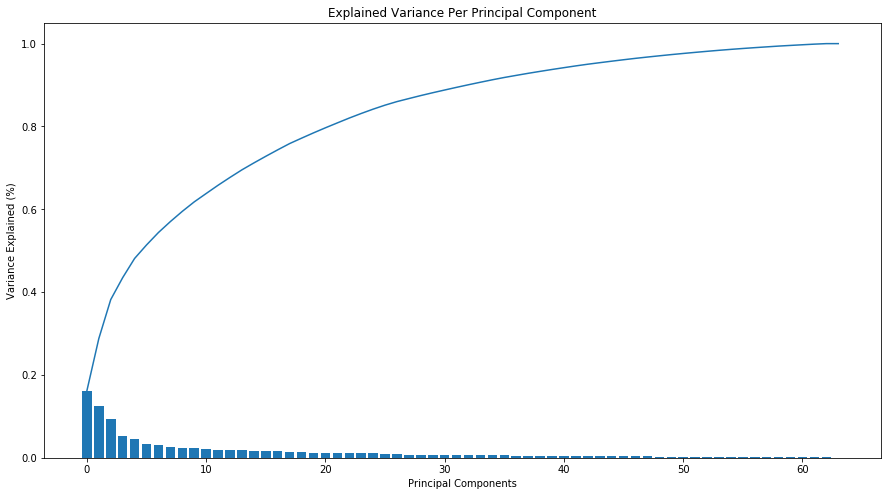

In [12]:
scree_plot(azdias_pca_fit)

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=41)
azdias_pca = pca.fit_transform(azdias)
azdias_pca.shape

(797073, 41)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I chose 41 principal components, because they contribute to >=90% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [14]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_feature_weight(pca, i, features):
    feature_weight_map = pd.DataFrame({'weight': pca.components_[i],
                                        'feature': features})
    feature_weight_map = feature_weight_map.sort_values(by='weight', ascending=False)
    top_5_map = feature_weight_map.iloc[:5]
    bottom_5_map = feature_weight_map.iloc[-5:]
    print('Top 5 features: ', top_5_map)
    print('Bottom 5 features: ', bottom_5_map)

In [15]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_feature_weight(pca, 0, azdias.columns)

Top 5 features:                     feature    weight
52              PLZ8_ANTG3  0.219504
62  CAMEO_INTL_2015_WEALTH  0.207239
42                EWDICHTE  0.196229
3            FINANZ_SPARER  0.182460
57             ORTSGR_KLS9  0.179359
Bottom 5 features:                feature    weight
40          KBA05_GBZ -0.205503
36        KBA05_ANTG1 -0.216380
50         PLZ8_ANTG1 -0.216882
2   FINANZ_MINIMALIST -0.224954
46         MOBI_REGIO -0.225394


In [16]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_feature_weight(pca, 1, azdias.columns)

Top 5 features:                   feature    weight
0   ALTERSKATEGORIE_GROB  0.245691
4       FINANZ_VORSORGER  0.225073
17             SEMIO_ERL  0.213630
16            SEMIO_LUST  0.169250
10        RETOURTYP_BK_S  0.166754
Bottom 5 features:                           feature    weight
23                 SEMIO_PFLICHT -0.220955
6          FINANZ_UNAUFFAELLIGER -0.223040
3                  FINANZ_SPARER -0.226077
13                     SEMIO_REL -0.233975
60  PRAEGENDE_JUGENDJAHRE_DECADE -0.236632


In [17]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_feature_weight(pca, 2, azdias.columns)

Top 5 features:         feature    weight
15  SEMIO_VERT  0.346955
11   SEMIO_SOZ  0.297710
18  SEMIO_KULT  0.288552
12   SEMIO_FAM  0.227158
53  PLZ8_ANTG4  0.107476
Bottom 5 features:         feature    weight
17   SEMIO_ERL -0.178588
20  SEMIO_KRIT -0.310928
21   SEMIO_DOM -0.318781
1    ANREDE_KZ -0.339945
22  SEMIO_KAEM -0.344590


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The 1st principal component has positively related features of the larger house size, wealth, households density, and community size. It has negatively related features of the smaller house size and lower finanical awareness.

The 2nd principal component has positively related features of the older ages, higher financial awareness, easily distracted personality, and lower returning rate after shopping. It has negatively related features that are the opposite as the features before.

The 3rd principal component has positively related features of mostly the more easily influencable personality and larger house size. It has negatively related features that have the more assertive personality and male gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [18]:
# Over a number of different cluster counts...
n_clusters = list(range(1,30,3))
scores = {}
for i in n_clusters:
    # run k-means clustering on the data and...
    print ('Number of clusters: ', i)
    kmeans = KMeans(i)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    score = abs(model.score(azdias_pca))
    print('SSE: ', score)
    scores[i] = score
scores    

Number of clusters:  1
SSE:  48049611.5958
Number of clusters:  4
SSE:  36266506.1728
Number of clusters:  7
SSE:  32049845.1275
Number of clusters:  10
SSE:  29474160.275
Number of clusters:  13
SSE:  27923783.0635
Number of clusters:  16
SSE:  26968191.4637
Number of clusters:  19
SSE:  26011341.4549
Number of clusters:  22
SSE:  24956100.8194
Number of clusters:  25
SSE:  24342084.559
Number of clusters:  28
SSE:  23856709.1431


{1: 48049611.595795855,
 4: 36266506.172815375,
 7: 32049845.127466302,
 10: 29474160.275049869,
 13: 27923783.063511152,
 16: 26968191.463731933,
 19: 26011341.454925068,
 22: 24956100.819415156,
 25: 24342084.55897563,
 28: 23856709.143082403}

Text(0,0.5,'SSE, average distance from centroids')

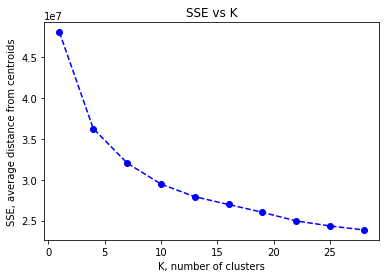

In [19]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(scores.keys(), scores.values(), linestyle='--', marker='o', color='b')
plt.title('SSE vs K')
plt.xlabel('K, number of clusters')
plt.ylabel('SSE, average distance from centroids')

In [17]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(18)
model = kmeans.fit(azdias_pca)
labels = model.predict(azdias_pca)

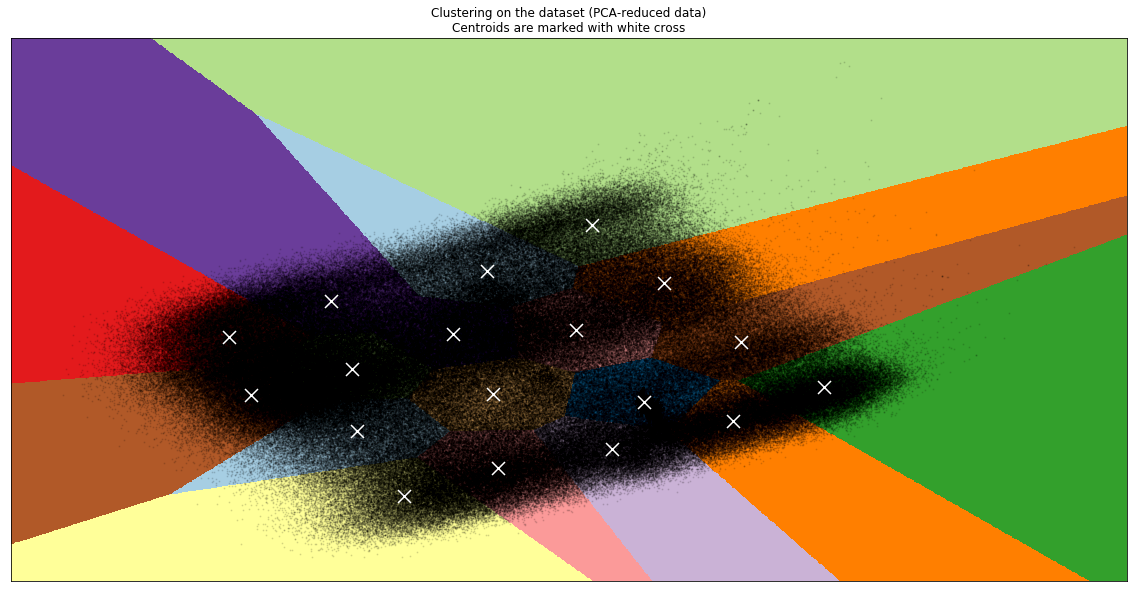

In [19]:
reduced_data = PCA(n_components=2).fit_transform(azdias)
clusters = KMeans(n_clusters=18, random_state=100).fit(reduced_data)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))


Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_

def PCA_plot(Z, centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(20, 10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2, alpha=0.1)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

PCA_plot(Z, centroids)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I chose 18 clusters because more clusters no longer lead to a large decrease in avg distance.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [18]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [19]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is tryin

In [20]:
customers_imputed = pd.DataFrame(imp.transform(customers), columns=customers.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns=customers_imputed.columns)

In [21]:
customers_pca = pca.transform(customers_scaled)
customers_pca.shape

(141589, 41)

In [22]:
customers_labels = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In step 1.1.3, the value distribution of two subsets (one with <20 missing values per row, the other one with >=20 missing values per row) is the same. 

So I won't add back the second subset with many missing values for neither the general population dataset nor the customer dataset. 

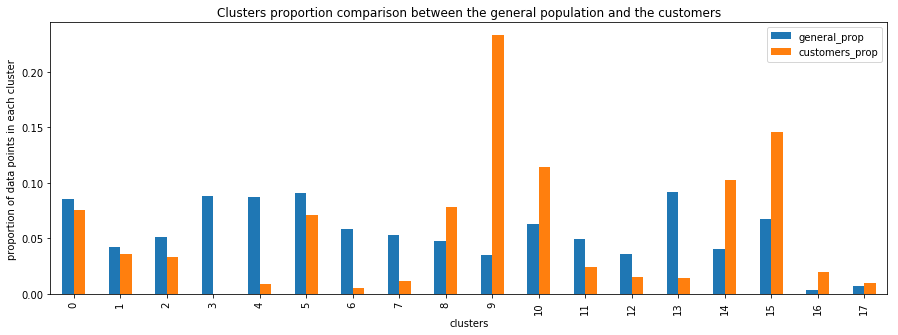

In [23]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

labels_count = np.bincount(labels)
customers_labels_count = np.bincount(customers_labels)
labels_prop = [float(i/len(labels)) for i in labels_count]
customers_labels_prop = [float(i/len(customers_labels)) for i in customers_labels_count]

df_prop = pd.DataFrame({'clusters': np.arange(18), 'general_prop': labels_prop, 'customers_prop': customers_labels_prop})
df_prop.plot(x='clusters', y = ['general_prop', 'customers_prop'], kind='bar', figsize=(15,5))
plt.title('Clusters proportion comparison between the general population and the customers')
plt.ylabel('proportion of data points in each cluster')
plt.show()

In [77]:
def features_in_customer_cluster(kmeans, cluster_idx):
    pca_in_this_cluster = customers_pca[np.where(customers_labels==cluster_idx)]
    features_in_this_cluster = scaler.inverse_transform(pca.inverse_transform(pca_in_this_cluster)).round()
    df_in_this_cluster = pd.DataFrame(data= features_in_this_cluster, columns= customers_scaled.columns)
    for col in df_in_this_cluster:
        print(df_in_this_cluster[col].value_counts())

In [78]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

features_in_customer_cluster(kmeans, 9)

4.0    22948
3.0     9032
5.0      870
2.0       97
1.0       27
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    32974
Name: ANREDE_KZ, dtype: int64
5.0    28308
4.0     2759
6.0     1629
3.0      277
2.0        1
Name: FINANZ_MINIMALIST, dtype: int64
1.0    29615
0.0     1779
2.0     1472
3.0       72
4.0       36
Name: FINANZ_SPARER, dtype: int64
5.0    28591
4.0     2278
6.0     1752
3.0      309
2.0       40
1.0        4
Name: FINANZ_VORSORGER, dtype: int64
 1.0    22754
 0.0     7679
 2.0     2317
 3.0      202
 4.0       14
-1.0        6
 5.0        2
Name: FINANZ_ANLEGER, dtype: int64
2.0    19403
1.0    11981
3.0     1445
0.0       67
4.0       63
5.0       15
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    22045
3.0     6158
4.0     2096
1.0     2032
5.0      632
0.0       10
6.0        1
Name: FINANZ_HAUSBAUER, dtype: int64
 1.0    30510
-0.0     2464
Name: GREEN_AVANTGARDE, dtype: int64
1.0    19184
2.0    11444
3.0     2346
Name: HEALTH_TYP, dtype: int64
5.0    19858
3.0  

In [79]:
features_in_customer_cluster(kmeans, 15)

3.0    11281
4.0     8566
5.0      456
2.0      283
1.0       44
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    20559
2.0       71
Name: ANREDE_KZ, dtype: int64
5.0    17100
4.0     2597
6.0      608
3.0      309
2.0       16
Name: FINANZ_MINIMALIST, dtype: int64
1.0    14725
2.0     3969
0.0     1054
3.0      596
4.0      279
5.0        7
Name: FINANZ_SPARER, dtype: int64
5.0    14061
4.0     4109
6.0     1128
3.0     1021
2.0      283
1.0       28
Name: FINANZ_VORSORGER, dtype: int64
1.0    9578
2.0    7479
3.0    2633
4.0     478
0.0     375
5.0      87
Name: FINANZ_ANLEGER, dtype: int64
1.0    9331
2.0    9022
3.0    1782
4.0     253
0.0     184
5.0      58
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    11066
1.0     4990
3.0     2885
4.0     1316
5.0      280
0.0       92
6.0        1
Name: FINANZ_HAUSBAUER, dtype: int64
-0.0    20054
 1.0      576
Name: GREEN_AVANTGARDE, dtype: int64
3.0    8611
2.0    8523
1.0    3496
Name: HEALTH_TYP, dtype: int64
3.0    8032
5.0    6539
4.0

The cluster No.9 and No.15 have similar type of people. They are mostly: older than 46, male, have average income, have a long residence period, live in the area with mostly 1-2 family houses, and more wealthy.


In [83]:
def features_in_general_cluster(kmeans, cluster_idx):
    pca_in_this_cluster = azdias_pca[np.where(labels==cluster_idx)]
    features_in_this_cluster = scaler.inverse_transform(pca.inverse_transform(pca_in_this_cluster)).round()
    df_in_this_cluster = pd.DataFrame(data= features_in_this_cluster, columns= azdias.columns)
    for col in df_in_this_cluster:
        print(df_in_this_cluster[col].value_counts())

In [84]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

features_in_general_cluster(kmeans, 3)

2.0    51175
3.0    17849
1.0     1417
4.0      106
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    39096
1.0    31451
Name: ANREDE_KZ, dtype: int64
3.0    67883
2.0     1284
4.0      804
1.0      472
5.0       93
0.0       11
Name: FINANZ_MINIMALIST, dtype: int64
4.0    69331
5.0      585
3.0      261
2.0      222
1.0      147
0.0        1
Name: FINANZ_SPARER, dtype: int64
3.0    67481
2.0     2451
1.0      350
5.0      132
4.0      119
6.0       14
Name: FINANZ_VORSORGER, dtype: int64
5.0    68205
4.0     1789
3.0      370
2.0      141
6.0       33
1.0        9
Name: FINANZ_ANLEGER, dtype: int64
5.0    69233
4.0      671
6.0      335
3.0      243
2.0       65
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
3.0    66891
1.0     1741
4.0      865
2.0      747
5.0      279
0.0       24
Name: FINANZ_HAUSBAUER, dtype: int64
-0.0    70513
 1.0       34
Name: GREEN_AVANTGARDE, dtype: int64
3.0    68944
2.0     1584
1.0       19
Name: HEALTH_TYP, dtype: int64
3.0    47453
5.0    10037
1.0     4780

In [85]:
features_in_general_cluster(kmeans, 13)

2.0    36001
1.0    28580
3.0     8806
0.0       80
4.0       20
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    72640
1.0      847
Name: ANREDE_KZ, dtype: int64
1.0    21130
2.0    20748
3.0    19539
4.0    10195
5.0     1269
0.0      606
Name: FINANZ_MINIMALIST, dtype: int64
4.0    43901
5.0    16782
3.0     6783
2.0     4911
1.0     1103
0.0        6
6.0        1
Name: FINANZ_SPARER, dtype: int64
2.0    40104
3.0    18123
1.0    10350
4.0     3756
5.0      997
6.0      133
0.0       24
Name: FINANZ_VORSORGER, dtype: int64
5.0    33052
4.0    25126
3.0     9198
6.0     3692
2.0     2193
1.0      223
7.0        2
0.0        1
Name: FINANZ_ANLEGER, dtype: int64
4.0    34524
5.0    21473
3.0    10538
2.0     5162
1.0     1180
6.0      554
0.0       56
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
4.0    17340
2.0    15185
3.0    15089
1.0    14908
5.0    10316
0.0      642
6.0        7
Name: FINANZ_HAUSBAUER, dtype: int64
0.0    59967
1.0    13520
Name: GREEN_AVANTGARDE, dtype: int64
3.0   

The cluster No.3 and No.13 have similar type of people. They are mostly: younger than 45, single, live in a densely populated area, low financial awareness, and lower class. 


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The following segments of the population are more popular with the mail-order company: older than 46, male, have average income, have a long residence period, live in the area with mostly 1-2 family houses, and more wealthy. 

The following segments of the population are less popular with the mail-order company: younger than 45, single, live in a densely populated area, low financial awareness, and lower class. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.